In [2]:
from preprocess import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Function
from sklearn.model_selection import train_test_split

device = "cuda"

In [3]:
train_data_list = load_data2("train")
test_data_list = load_data2("test")

In [4]:
class FeatureExtractorEEG(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(5, 32, kernel_size=3, padding=1),  # (32,8,9)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (64,8,9)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # (64,4,4)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (128,4,4)
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((1, 1))  # (128,1,1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # (batch, 128)
        return x

class FeatureExtratorEYE(nn.Module):
    def __init__(self, input_dim=33, hidden_dim1=256, hidden_dim2=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        return x


In [5]:
class FeatureFusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.eeg = FeatureExtractorEEG()
        self.eye = FeatureExtratorEYE()
        self.classifier = nn.Linear(256, 3)

    def forward(self, x_eeg, x_eye):
        feat = torch.cat([self.eeg(x_eeg), self.eye(x_eye)], dim = 1)
        output = self.classifier(feat)
        return output

In [14]:
batch_size = 32
epochs = 100
# patience = 15

acc_list = []

# for i in [2]:
for i in range(12):

    X_EEG_train, X_EYE_train, Y_train = train_data_list[i]
    X_EEG_test, X_EYE_test, Y_test = test_data_list[i]

    # (
    #     X_EEG_train, X_EEG_val,
    #     X_EYE_train, X_EYE_val,
    #     Y_train, Y_val
    # ) = train_test_split(
    #     X_EEG_train,  
    #     X_EYE_train, 
    #     Y_train,      
    #     test_size=0.2,     
    #     stratify=Y_train,   
    #     random_state=42     
    # )

    eeg_scaler, X_EEG_train = fit_transform(X_EEG_train)
    X_EEG_test = transform(eeg_scaler, X_EEG_test)

    eye_scaler, X_EYE_train = fit_transform(X_EYE_train)
    X_EYE_test = transform(eye_scaler, X_EYE_test)

    train_dataset = FusionDataset(X_EEG_train, X_EYE_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    test_dataset = FusionDataset(X_EEG_test, X_EYE_test, Y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # X_EEG_val = transform(eeg_scaler, X_EEG_val)
    # X_EYE_val = transform(eye_scaler, X_EYE_val)

    # val_dataset = FusionDataset(X_EEG_val, X_EYE_val, Y_val)
    # val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = FeatureFusion().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=4e-4)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    
    for epoch in range(epochs):
        model.train()

        correct_train = 0
        total_train = 0
        total_loss = 0  

        for x_eeg, x_eye, y in train_loader:
            x_eeg, x_eye, y = x_eeg.to(device), x_eye.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x_eeg, x_eye)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss

            pred = out.argmax(dim=1)
            correct_train += (pred == y).sum().item()
            total_train += y.size(0)


        train_acc = correct_train / total_train
        total_loss = total_loss / len(train_dataset)

        # val_acc = get_acc(model, val_loader)

        # if val_acc > best_val_acc:
        #     best_val_acc = val_acc
        #     patience_counter = 0 
        #     best_model_state = {k: v.cpu().detach() for k, v in model.state_dict().items()}
        #     print(f"New best test acc: {val_acc:.4f} at epoch {epoch+1}")
        # else:
        #     patience_counter += 1
        #     print(f"No improvement for {patience_counter} epochs. Best: {best_val_acc:.4f}")

        # if patience_counter >= patience: break

        test_acc = get_acc(model, test_loader)

        if epoch % 5 == 4 or True: print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.4f}, loss = {total_loss:.4f} Test Acc: {test_acc:.4f}")
        
        if train_acc > 0.95: break

    # model.load_state_dict(best_model_state)
    acc_list.append(get_acc(model, test_loader))
    print(f"acc {i} = {acc_list[-1]}")



Epoch 1/100, Train Acc: 0.3641, loss = 0.0351 Test Acc: 0.3965
Epoch 2/100, Train Acc: 0.5311, loss = 0.0315 Test Acc: 0.5034
Epoch 3/100, Train Acc: 0.5945, loss = 0.0296 Test Acc: 0.5607
Epoch 4/100, Train Acc: 0.6513, loss = 0.0282 Test Acc: 0.5258
Epoch 5/100, Train Acc: 0.6981, loss = 0.0271 Test Acc: 0.5705
Epoch 6/100, Train Acc: 0.7295, loss = 0.0262 Test Acc: 0.6035
Epoch 7/100, Train Acc: 0.7769, loss = 0.0253 Test Acc: 0.6385
Epoch 8/100, Train Acc: 0.7742, loss = 0.0248 Test Acc: 0.6113
Epoch 9/100, Train Acc: 0.7882, loss = 0.0242 Test Acc: 0.5850
Epoch 10/100, Train Acc: 0.8056, loss = 0.0236 Test Acc: 0.6200
Epoch 11/100, Train Acc: 0.8150, loss = 0.0231 Test Acc: 0.5938
Epoch 12/100, Train Acc: 0.8236, loss = 0.0225 Test Acc: 0.5870
Epoch 13/100, Train Acc: 0.8297, loss = 0.0222 Test Acc: 0.6006
Epoch 14/100, Train Acc: 0.8383, loss = 0.0218 Test Acc: 0.5909
Epoch 15/100, Train Acc: 0.8464, loss = 0.0213 Test Acc: 0.5918
Epoch 16/100, Train Acc: 0.8677, loss = 0.0209 Te

[0.6297376093294461, 0.7959183673469388, 0.6219630709426628, 0.586977648202138, 0.7512147716229349, 0.6180758017492711, 0.8182701652089407, 0.7162293488824101, 0.8007774538386784, 0.6676384839650146, 0.652089407191448, 0.8309037900874635]
LOSO Mean Accuracy: 0.7075, Std: 0.0849


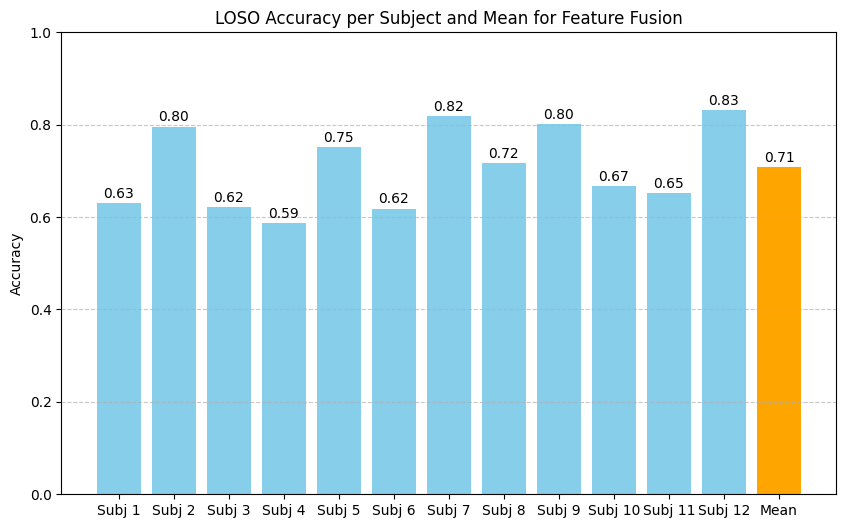

In [16]:
print(acc_list)
mean_acc = np.mean(acc_list)
std_acc = np.std(acc_list)
print(f"LOSO Mean Accuracy: {mean_acc:.4f}, Std: {std_acc:.4f}")

x_labels = [f"Subj {i}" for i in range(1, 13)] + ["Mean"]
# 对应柱子高度
y_values = acc_list + [mean_acc]

# 绘制柱状图
plt.figure(figsize=(10,6))
bars = plt.bar(x_labels, y_values, color=['skyblue']*12 + ['orange'])

# 在柱子上显示数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.2f}", ha='center', va='bottom')

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("LOSO Accuracy per Subject and Mean for Feature Fusion")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

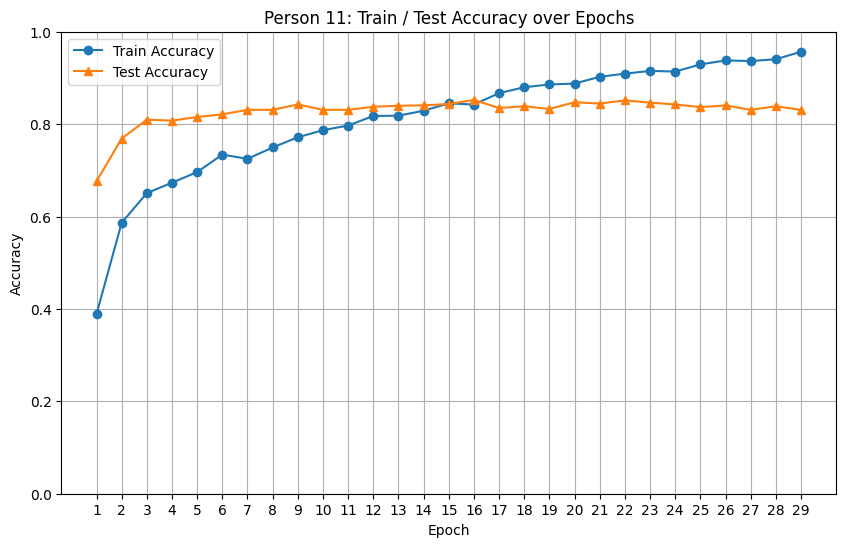

In [20]:
import matplotlib.pyplot as plt

# 训练准确率 (Train Acc)
train_acc = [
    0.3888, 0.5865, 0.6506, 0.6733, 0.6961, 0.7341, 0.7248, 0.7495, 0.7715, 0.7869,
    0.7969, 0.8176, 0.8183, 0.8290, 0.8450, 0.8424, 0.8671, 0.8798, 0.8858, 0.8878,
    0.9025, 0.9092, 0.9152, 0.9138, 0.9292, 0.9379, 0.9365, 0.9405, 0.9566
]

# 测试准确率 (Test Acc)
test_acc = [
    0.6764, 0.7687, 0.8095, 0.8076, 0.8154, 0.8212, 0.8309, 0.8309, 0.8426, 0.8309,
    0.8309, 0.8377, 0.8397, 0.8406, 0.8435, 0.8523, 0.8348, 0.8387, 0.8328, 0.8474,
    0.8445, 0.8513, 0.8465, 0.8426, 0.8367, 0.8406, 0.8309, 0.8387, 0.8309
]

# 构建 x 轴：1-base epoch
epochs = list(range(1, len(train_acc)+1))  # 1,2,...20

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, test_acc, marker='^', label='Test Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Person 11: Train / Test Accuracy over Epochs')
plt.xticks(epochs)
plt.ylim(0, 1.0)
plt.grid(True)
plt.legend()
plt.show()
